In [0]:
import torch
import numpy as np

In [0]:
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [3]:
dataset = MNIST(root='sample_data/',download=True,transform=ToTensor())

Extracting sample_data/MNIST/raw/train-images-idx3-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/train-labels-idx1-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/t10k-images-idx3-ubyte.gz to sample_data/MNIST/raw


Extracting sample_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to sample_data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Train, Validation, Testing Sets

In [0]:
def split_indices(n,val_pct):
  # Determing size of validaton set
  n_val = int(val_pct*n)
  # Create Random permutations of 0 to n-1
  idxs = np.random.permutation(n)
  # Pick first n_val indices for validation set
  return idxs[n_val:],idxs[:n_val]

In [5]:
train_indicies, val_indicies = split_indices(len(dataset),val_pct=0.2)

In [0]:
batch_size = 100

#Training sampler and dataloader
train_sampler = SubsetRandomSampler(train_indicies)
train_loader = DataLoader(dataset,batch_size,sampler=train_sampler)

#Validation smapler and dataloader
val_sampler = SubsetRandomSampler(val_indicies)
val_loader = DataLoader(dataset,batch_size,sampler=val_sampler)

### Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class MnistModel(nn.Module):
  #Feed Forward Netwrok with 1 hidden layer
  def __init__(self,in_size,hidden_size,out_size):
    super().__init__()
    #hidden layer
    self.linear1 = nn.Linear(in_size,hidden_size)
    #output layer
    self.linear2 = nn.Linear(hidden_size,out_size)
  
  def forward(self, xb):
    #Flatten the image tensors
    xb = xb.view(xb.size(0),-1)
    #Get Intermediate outputs using hidden layer
    out = self.linear1(xb)
    #Apply activation function
    out = F.relu(out)
    # Get predictions using output layer
    out = self.linear2(out)
    out = F.softmax(out,dim=1)
    return out

In [0]:
input_size = 784
num_classes = 10

model = MnistModel(input_size, hidden_size=32,out_size=num_classes)

In [9]:
for t in model.parameters():
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [10]:
for images, labels in train_loader:
  outputs = model(images)
  loss = F.cross_entropy(outputs,labels)
  print('Loss:', loss.item())
  break

Loss: 2.3016555309295654


### On GPUs

In [11]:
torch.cuda.is_available()

True

In [0]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [13]:
device = get_default_device()
device

device(type='cuda')

In [0]:
def to_device(data,device):
  """Funciton that can move data to choosen device"""
  if isinstance(data,(list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking=True)

In [15]:
for images, labels in train_loader:
  print(images.shape)
  images = to_device(images,device)
  print(images.device)
  break

torch.Size([100, 1, 28, 28])
cuda:0


- Finally we define a DeviceDataLoader class to wrap our exsisting data loaders and move data to the selected device, as a batches are accessed.
- Intrestingly, we don't need to extend an exsisting class to create a PyTorch dataloader. All we need is an _ _ iter _ _ method to retrieve batches of data, and an _ _ len _ _ method to get the number of batches

In [0]:
class DeviceDataLoader():
  """ Wrap a data loader to move data to a device """
  
  def __init__ (self,dl,device):
    self.dl = dl
    self.device = device
  
  def __iter__(self):
    """ Yield a batch of data after moving it to a device """
    for b in self.dl:
      yield to_device(b,self.device)
  
  def __len__(self):
    """ Number of batches """
    return len(self.dl)

In [0]:
train_dl = DeviceDataLoader(train_loader,device)
valid_dl = DeviceDataLoader(val_loader,device)

### Training the model

In [0]:
def loss_batch(model,loss_fn,xb,yb,opt=None,metric=None):
  preds = model(xb)
  loss = loss_fn(preds,yb)

  if opt is not None:
    loss.backward()
    opt.step()
    opt.zero_grad()
  
  metric_result = None
  
  if metric is not None:
    metric_result = metric(preds,yb)
  
  return loss.item(),len(xb),metric_result

In [0]:
#Evaluation Metric not Loss function
def accuracy(output,labels):
  _, preds = torch.max(output,dim=1)
  return torch.sum(preds == labels).item()/len(preds)

In [0]:
def evaluate(model,loss_fn,valid_dl,metric=None):
  with torch.no_grad():
    #Pass each batch through the model
    results = [loss_batch(model,loss_fn,xb,yb,metric=metric) for xb,yb in valid_dl]
    #Seperate losses, counts and metrics
    losses, nums, metrics = zip(*results)
    #Total size of the dataset
    total = np.sum(nums)
    #Avg. loss across batches
    avg_loss = np.sum(np.multiply(losses,nums))/total
    avg_metric = None
    if metric is not None:
      avg_metric = np.sum(np.multiply(metrics,nums))/total
  return avg_loss, total, avg_metric

In [21]:
loss_fn = F.cross_entropy
print(evaluate(model,loss_fn,val_loader,metric=accuracy))

(2.302324398358663, 12000, 0.09241666666666666)


In [0]:
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

In [0]:
def fit(epochs,model,loss_fn,opt,train_dl,valid_dl,metric=None):
  for epoch in range(epochs):
    #Training
    for xb,yb in train_dl:
      loss,_,_ = loss_batch(model,loss_fn,xb,yb,opt)
    #Evaluation
    result = evaluate(model,loss_fn,valid_dl,metric)
    val_loss, total, val_metric = result
    #Print progress
    if metric is None:
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1,epochs,val_loss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch+1,epochs,val_loss,metric.__name__,val_metric))

In [24]:
fit(100,model,loss_fn,optimizer,train_loader,val_loader,accuracy)

Epoch [1/100], Loss: 1.8597, accuracy: 0.6434
Epoch [2/100], Loss: 1.7370, accuracy: 0.7788
Epoch [3/100], Loss: 1.6139, accuracy: 0.8867
Epoch [4/100], Loss: 1.5854, accuracy: 0.9010
Epoch [5/100], Loss: 1.5743, accuracy: 0.9051
Epoch [6/100], Loss: 1.5662, accuracy: 0.9103
Epoch [7/100], Loss: 1.5617, accuracy: 0.9123
Epoch [8/100], Loss: 1.5569, accuracy: 0.9163
Epoch [9/100], Loss: 1.5540, accuracy: 0.9182
Epoch [10/100], Loss: 1.5508, accuracy: 0.9209
Epoch [11/100], Loss: 1.5480, accuracy: 0.9227
Epoch [12/100], Loss: 1.5471, accuracy: 0.9224
Epoch [13/100], Loss: 1.5443, accuracy: 0.9256
Epoch [14/100], Loss: 1.5421, accuracy: 0.9265
Epoch [15/100], Loss: 1.5407, accuracy: 0.9279
Epoch [16/100], Loss: 1.5394, accuracy: 0.9285
Epoch [17/100], Loss: 1.5380, accuracy: 0.9291
Epoch [18/100], Loss: 1.5365, accuracy: 0.9310
Epoch [19/100], Loss: 1.5348, accuracy: 0.9330
Epoch [20/100], Loss: 1.5352, accuracy: 0.9327
Epoch [21/100], Loss: 1.5325, accuracy: 0.9354
Epoch [22/100], Loss: 

### Testing

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
testDataset = MNIST(root='sample_data',download= True,train=False,transform=ToTensor())

In [0]:
i = 29

In [37]:
_,pred = torch.max(model(testDataset[i][0]),dim=1)
pred.item()

1

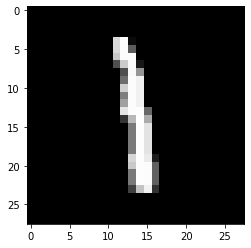

In [38]:
plt.imshow(testDataset[i][0][0,:,:],cmap='gray')